<a href="https://colab.research.google.com/github/ravi2799/CNN_Furniture_Classification/blob/main/dataset1_mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import time
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.decomposition import PCA
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns
import seaborn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [15]:
writer = SummaryWriter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
from google.colab import drive
drive.mount('/content/gdrive/');

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

cpu
Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
cpu
Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [16]:
def load_Data():
    train_dataset = datasets.ImageFolder("/content/gdrive/MyDrive/Final_Dataset/dataset1/train", transform=transform)
    val_dataset = datasets.ImageFolder("/content/gdrive/MyDrive/Final_Dataset/dataset1/val", transform=test_transform)
    test_dataset = datasets.ImageFolder("/content/gdrive/MyDrive/Final_Dataset/dataset1/test", transform=test_transform)

    print(train_dataset.class_to_idx)
    #print(test_dataset.class_to_idx)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader,val_loader,test_loader
load_Data()

{'Cat': 0, 'Dog': 1}


(<torch.utils.data.dataloader.DataLoader at 0x7f46bf6c77c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f4714ea7160>)

{'Cat': 0, 'Dog': 1}


(<torch.utils.data.dataloader.DataLoader at 0x7f46bcd0ca00>,
 <torch.utils.data.dataloader.DataLoader at 0x7f46bcd0cf40>)

In [17]:
class Model(nn.Module):
  def __init__(self,input) -> None:
      super(Model,self).__init__()
      self.model = torchvision.models.mobilenet_v2(pretrained=False)
      #self.num_ftrs = self.model.classifier[1].in_features
      #print(num_ftrs)
      self.fc_layer = nn.Sequential(
      nn.Linear(1280,640),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.1),
      
      nn.Linear(640,320),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.1),
      
      nn.Linear(320,160),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.1),
      nn.Linear(160, 2)
    )
      
      self.model.classifier = self.fc_layer
      self.features = {}
      self.model.classifier.register_forward_pre_hook(self.get_features("embeddings"))
  def get_features(self,name):
      def hook(model, input):
          self.features[name] = input[0].detach().cpu().numpy()
      return hook
  def forward(self, x):
        x = self.model(x)
        return x
model = Model((224,224))
print(model)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model(
  (model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), st

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [18]:

# def Model():
#     model = torchvision.models.mobilenet_v2(pretrained=False)
#     num_ftrs = model.classifier[1].in_features
#     print(num_ftrs)
#     model.classifier = nn.Sequential(
#     nn.Linear(num_ftrs,640),
#     nn.ReLU(inplace=True),
#     nn.Dropout(p=0.1),
    
#     nn.Linear(640,320),
#     nn.ReLU(inplace=True),
#     nn.Dropout(p=0.1),
    
#     nn.Linear(320,160),
#     nn.ReLU(inplace=True),
#     nn.Dropout(p=0.1),
    
#     nn.Linear(160, 2)
#     )
    
#     return model.to(device)
# Model()



In [19]:
def save_checkpoint(state, filename):
    torch.save(state, filename)


In [20]:
y_train = []
y_expected_train = []
y_val = []
y_expected_val = []
y_test = []
y_expected_test = []

In [21]:
print(torch.cuda.is_available())
def train(model, train_loader, criterion, optimizer, epoch, step=5):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        #print(torch.cuda.is_available())
        total =0
        correct = 0
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        #print(predicted,type(predicted))
        #print(labels,type(labels))
        output = model(images)
        
        loss = criterion(output,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output.data, 1)
        y_train.extend(predicted.to(torch.device('cpu')))
        y_expected_train.extend(labels.to(torch.device('cpu')))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        #print( f'Training Accuracy: {accuracy:.2f}%')
            
        if i%step==0:
            print('EPOCH {} | ITER {} | AVG_LOSS {} | Train_ACC {}'.format(epoch, i, loss,accuracy))
        writer.add_scalar('TRAIN_LOSS', loss, epoch)
        
    return loss ,accuracy

False
False


In [22]:
def val(model, test_loader, criterion, optimizer, epoch, step=5):
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            #print(inputs.shape)
            #print(labels.shape)
            labels = labels.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            #print(predicted,type(predicted))
            #print(labels,type(labels))
            y_val.extend(predicted.to(torch.device('cpu')))
            y_expected_val.extend(labels.to(torch.device('cpu')))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            print(f'Val Accuracy: {accuracy:.2f}%')
            return accuracy
    

In [23]:
def test(model, test_loader, criterion, optimizer, epoch, step=5):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            #print(inputs.shape)
            #print(labels.shape)
            labels = labels.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            #print(predicted,type(predicted))
            #print(labels,type(labels))
            y_test.extend(predicted.to(torch.device('cpu')))
            y_expected_test.extend(labels.to(torch.device('cpu')))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            print(f'Test Accuracy: {accuracy:.2f}%')
            return accuracy
    

In [24]:
def visualize(model , data_loader):
  
    class2idx = {'Dog': 0, 'Cat': 1}
    idx2class = { value : key for key,value in  class2idx.items() }
    print(idx2class)
    embeddings = np.array([])
    labels = np.array([])
    model.eval()
    out_features = 1280
    num_categories = 2
    with torch.no_grad(): 
        for i,data in enumerate(data_loader):
            images, labs = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            embeds = model.features["embeddings"].reshape(-1, 1280)
            embeddings = np.append(embeddings , embeds)
            labels = np.append(labels,labs.cpu())
    
    # model.train()
    embeddings = embeddings.reshape(-1, 1280)
    print(embeddings)
    
    c_labels = labels.reshape(-1 , 1).ravel()
    tsne = TSNE(n_components=2).fit_transform(embeddings)
    labels = np.array([ idx2class[ele] for ele in c_labels])
    
    cmap = cm.get_cmap('tab20')
    
    for lab in range(num_categories):
        indices = (c_labels == lab)
        plt.scatter(tsne[indices, 0],tsne[indices, 1],c=np.array(cmap(lab)).reshape(1, 4),label=lab,alpha=1)
        plt.legend(fontsize='large', markerscale=2)
    plt.show()
  
# model = Model((224,224))
# train_loader, val_loader ,test_loader = load_Data()
# visualize(model,test_loader)



In [25]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score
import seaborn as sns
import seaborn
import matplotlib.pyplot as plt

class2idx = {'Cat':0,'Dog':1}
idx2class = { value : key  for key , value in class2idx.items() }

def plot_confusion_matrix(data, labels, metrics ,output_filename=None):

    [macro_precision , micro_precision , macro_recall , micro_recall] = metrics

    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(10,10))
 
    plt.suptitle("Confusion Matrix")
    plt.title(f"(Macro/Micro) Precision : {round(macro_precision,2)}/{round(micro_precision,2)}   :::::   (Macro/Micro) Recall : {round(macro_recall,2)}/{round(micro_recall,2)}")
 
    seaborn.set(font_scale=1)
    ax = seaborn.heatmap(data, annot=True, cmap="YlGnBu",linewidths=2 , fmt='d' ,cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
    
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()



False
{'Cat': 0, 'Dog': 1}
EPOCH 0 | ITER 0 | AVG_LOSS 0.6912282109260559 | Train_ACC 56.25
EPOCH 0 | ITER 5 | AVG_LOSS 0.659375786781311 | Train_ACC 59.375
EPOCH 0 | ITER 10 | AVG_LOSS 0.647006630897522 | Train_ACC 56.25
EPOCH 0 | ITER 15 | AVG_LOSS 0.7182594537734985 | Train_ACC 43.75
EPOCH 0 | ITER 20 | AVG_LOSS 0.6666779518127441 | Train_ACC 62.5
EPOCH 0 | ITER 25 | AVG_LOSS 0.6044519543647766 | Train_ACC 62.5
EPOCH 0 | ITER 30 | AVG_LOSS 0.6804208159446716 | Train_ACC 65.625
EPOCH 0 | ITER 35 | AVG_LOSS 0.6818426251411438 | Train_ACC 56.25
EPOCH 0 | ITER 40 | AVG_LOSS 0.6301356554031372 | Train_ACC 65.625
EPOCH 0 | ITER 45 | AVG_LOSS 0.5565542578697205 | Train_ACC 81.25
EPOCH 0 | ITER 50 | AVG_LOSS 0.6436489224433899 | Train_ACC 68.75
EPOCH 0 | ITER 55 | AVG_LOSS 0.7708070874214172 | Train_ACC 59.375
EPOCH 0 | ITER 60 | AVG_LOSS 0.6085472702980042 | Train_ACC 68.75
EPOCH 0 | ITER 65 | AVG_LOSS 0.5875065326690674 | Train_ACC 71.875
EPOCH 0 | ITER 70 | AVG_LOSS 0.624760627746582 | T

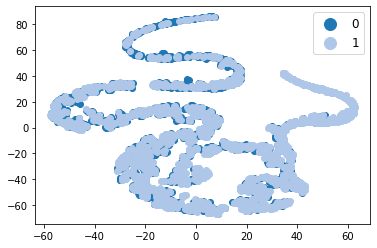

False
{'Cat': 0, 'Dog': 1}
EPOCH 0 | ITER 0 | AVG_LOSS 0.6887568831443787 | Train_ACC 53.125
EPOCH 0 | ITER 5 | AVG_LOSS 0.7001514434814453 | Train_ACC 43.75
EPOCH 0 | ITER 10 | AVG_LOSS 0.6783924698829651 | Train_ACC 53.125
EPOCH 0 | ITER 15 | AVG_LOSS 0.7751080989837646 | Train_ACC 46.875
EPOCH 0 | ITER 20 | AVG_LOSS 0.6720651388168335 | Train_ACC 62.5
EPOCH 0 | ITER 25 | AVG_LOSS 0.652334451675415 | Train_ACC 53.125


In [13]:
def main():
    model = Model((224,224));
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
        model = model.cuda()
        print("using gpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = 2

    train_loader, val_loader ,test_loader = load_Data()
    
    history = open("/content/gdrive/MyDrive/history.csv",'w')
    history.write('epochs , trainloss , val_acc , test_acc \n')
    max_accuracy = 0 
    for epoch in range(0,epochs):
        start = time.time()
        train_loss,accuracy = train(model, train_loader, criterion, optimizer, epoch)
        val_loss = val(model, val_loader, criterion, optimizer, epoch)
        test_loss = test(model, test_loader, criterion, optimizer, epoch)
        
        print()
        print('-' * 50)
        print('EPOCH {} | LOSS {} | TIME {}'.format(epoch, train_loss, time.time() - start))
        print('-' * 50)
        print()

        if(val_loss > max_accuracy):
          max_accuracy = val_loss
          save_checkpoint({'epoch': epoch,'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),'loss' : train_loss}, "/content/gdrive/MyDrive/Mobilenetv2_dataset1_checkpoint.ckpt")

        history.write('{},{},{},{},{}\n'.format(epoch, train_loss,accuracy, val_loss , test_loss))
        
    history.close()
    visualize(model,train_loader)
# Press the green button in the gutter to run the script.
if __name__ == '__main__':
    main()

In [ ]:
y_true = [  idx2class[val.item()] for val in y_expected_test ]
y_pred = [ idx2class[val.item()] for val in y_test ]

macro_precision = precision_score(y_true, y_pred, average="macro")
macro_recall = recall_score(y_true, y_pred, average="macro")
micro_precision = precision_score(y_true, y_pred, average="micro")
micro_recall = recall_score(y_true, y_pred, average="micro")

cnf_matrix = confusion_matrix(y_true , y_pred , labels=list(class2idx.keys()))
plot_confusion_matrix(cnf_matrix , class2idx.keys() , [macro_precision , micro_precision , macro_recall , micro_recall], output_filename = "cnf_mobilenet_Data1.png")